# Information about paper and code

## Code Authors
Erce Guder - Adnan Harun Dogan

## Paper Name:
FEW-SHOT CROSS-DOMAIN IMAGE GENERATION VIA INFERENCE-TIME LATENT-CODE LEARNING (ICLR2023) https://openreview.net/pdf?id=sCYXJr3QJM8

## Paper Summary
_"Can a GAN trained on a single large-scale source dataset be adapted to multiple target domains containing very few examples without re-training the pre-trained source generator?"_

The goal of the paper is to learn a latent-generation network (during inference stage) that maps random Gaussian noise to latents in the W space (style) of a pre-trained StyleGAN2 **without updating the generator** (we don't want to overfit / forget rich prior knowledge) such that the generator can sample from the target domain. There are two loss functions used to ensure that the samples belong to target domain:

  - Adversarial loss
  - Style Loss (Content Loss / VGG-Loss)

## Datasets: 
We shall take StyleGAN2 checkpoints trained on:
* *Flickr Faces HQ (FFHQ)* dataset. Our target domains will be

  - FFHQ-Babies,
  - FFHQ-Sunglasses, 
  - Face sketches, 
  - Emoji faces from bitmoji.com, 
  - Portrait paintings from the artistic faces dataset.

* *LSUN Church* as a source domain and adapt to
  - the haunted houses, 
  - Van Goh’s house paintings.

# Hyper-parameters of the model

As the authors of this paper also did, we took checkpoints that were presented by StyleGAN2 repositories. So, we are not sure if we should present the hyper-parameters of StyleGAN2.

Nevertheless, the hyper-parameters of StyleGAN2:
 - Output size of 256x256 pixels (generator & discriminator)
 - W dimension of 512 (generator)
 - Number of layers mapping Z to W: 8 (generator)

The latent generation network is decided to be (mentioned in the paper):
 - 3-Layer MLP with
 - ReLU activations

Rest of the hyper-parameters are as follows:
 - Learning rate for discriminator & latent generation network: 5e-4
 - Optimizer for discriminator & latent generation network:
     - Adam with betas (0.0, 0.99)
 - Batch size: 4

# Training and saving a model. 


In [1]:
from model import Generator, Discriminator
from latent_learner import LatentLearner
from dataset import Dataset
from tqdm import tqdm
import loss

import torch
import torchvision

import numpy as np
import matplotlib.pyplot as plt

import gc

def disable_grad(model):
    for _, param in model.named_parameters():
        param.requires_grad = False

def train(device):
    torch.manual_seed(796)
    np.random.seed(796)

    generator = Generator(size=256, style_dim=512, n_mlp=8).to(device)
    discriminator = Discriminator(size=256).to(device)
    latent_learner = LatentLearner().to(device)

    vgg = torchvision.models.vgg19(weights='IMAGENET1K_V1').features.to(device).eval()

    # No need for gradients on the parameters of these
    disable_grad(generator)
    disable_grad(vgg)

    # Take sub-networks from the vgg, later used to compute style loss
    subnetworks = loss.subnetworks(vgg, max_layers=5)

    # Garbage collection
    del vgg
    gc.collect()
    torch.cuda.empty_cache()

    # Load checkpoint and weights
    ckpt = torch.load("550000.pt")

    generator.load_state_dict(ckpt["g_ema"], strict=False)
    generator.eval()

    discriminator.load_state_dict(ckpt["d"])

    # Initialize optimizers (no optimizer for generator :)
    disc_opt = torch.optim.Adam(
        discriminator.parameters(),
        lr = 5e-4,
        betas = (0.0, 0.99)
    )
    latent_learner_opt = torch.optim.Adam(
        latent_learner.parameters(),
        lr = 5e-4,
        betas = (0.0, 0.99)
    )

    # Simple transformation pipeline
    transforms = torchvision.transforms.Compose([
        torchvision.transforms.Resize((256, 256)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])

    # Create simple dataset & loader
    dataset = Dataset(path="./babies", transforms=transforms)
    loader = torch.utils.data.DataLoader(dataset, batch_size=4, shuffle=True)

    # 
    x = torch.randn(10, 1024).to(device)

    # 150 iterations
    for iter_ in tqdm(range(50)):        
        for imgs in loader:
            imgs = imgs.to(device)

            x_idx = np.random.choice(len(x), size=imgs.shape[0])

            ##### Adversarial Loss ##### 
            # first forward pass
            w = latent_learner(x[x_idx])
            samples, _ = generator([w], input_is_latent=True)

            fake_scores = discriminator(samples)
            real_scores = discriminator(imgs)

            d_loss = loss.d_logistic_loss(real_scores, fake_scores)

            # optimization step on discriminator
            d_loss.backward()
            disc_opt.step()
            disc_opt.zero_grad()

            # second forward pass
            w = latent_learner(x[x_idx])
            samples, _ = generator([w], input_is_latent=True)

            fake_scores = discriminator(samples)

            g_loss = 5 * loss.g_nonsaturating_loss(fake_scores)

            # optimization step on latent learner
            g_loss.backward()
            latent_learner_opt.step()
            latent_learner_opt.zero_grad()

            ##### Style Loss #####
            w = latent_learner(x[x_idx])
            samples, _ = generator([w], input_is_latent=True)

            vgg_loss = 0.0

            for i, img in enumerate(imgs):
                vgg_loss += 50 * loss.style_loss(subnetworks, img, samples[i])

            # optimization step on latent learner
            vgg_loss.backward()
            latent_learner_opt.step()
            latent_learner_opt.zero_grad()

    return x, latent_learner, generator

/home/ceng796/miniconda3/envs/796/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
noise, latent_learner, generator = train(device)

  0%|                                                                                                                                              | 0/50 [00:00<?, ?it/s]/home/ceng796/inference-time-latent-code-learning/op/conv2d_gradfix.py:88: UserWarning: conv2d_gradfix not supported on PyTorch 1.13.1. Falling back to torch.nn.functional.conv2d().
  warnings.warn(
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [01:54<00:00,  2.29s/it]


# Loading a pre-trained model and computing qualitative samples/outputs from that model

In [4]:
import os

os.makedirs("ckpts", exist_ok=True)

torch.save(noise, "ckpts/noise.pt")
torch.save(latent_learner.state_dict(), "ckpts/latent_learner.pt")
torch.save(generator.state_dict(), "ckpts/generator.pt")

In [6]:
generator = Generator(size=256, style_dim=512, n_mlp=8).to(device)
generator.load_state_dict(torch.load("ckpts/generator.pt"))
generator.eval()

latent_learner = LatentLearner().to(device)
latent_learner.load_state_dict(torch.load("ckpts/latent_learner.pt"))

noise = torch.load("ckpts/noise.pt")

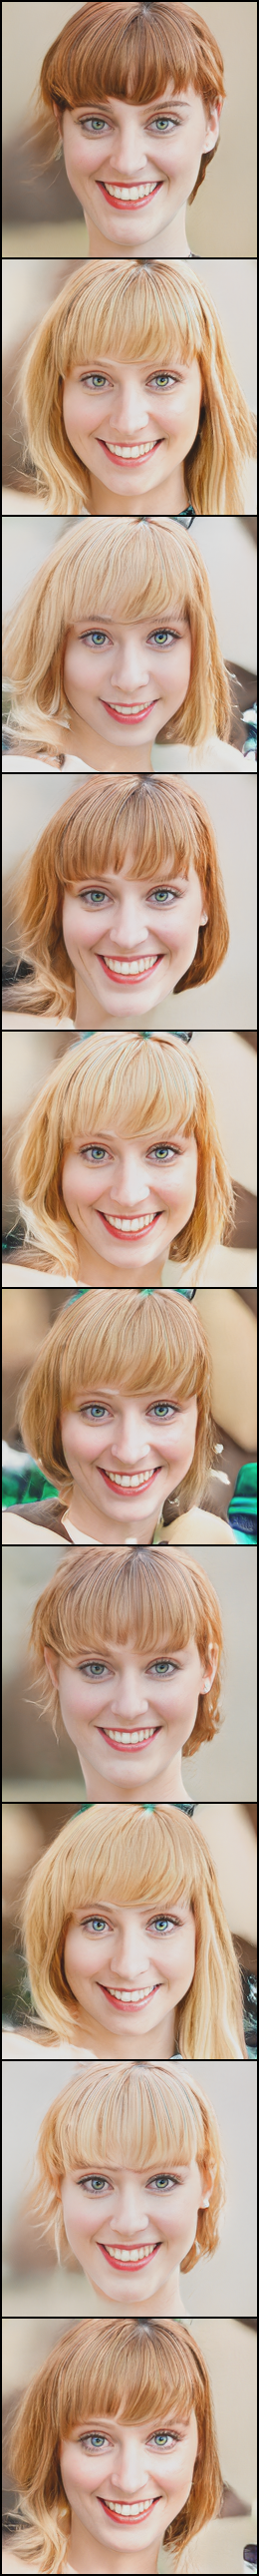

In [7]:
with torch.no_grad():
    # Map to latent
    w = latent_learner(noise)

    # Pass through Generator
    samples, _ = generator([w])

    # Save for later examination
    torchvision.utils.save_image(
        samples.detach(),
        "samples.png",
        nrow=1,
        normalize=True,
        range=(-1, 1),
    )

    from PIL import Image

    im = Image.open("samples.png")
    display(im)

**It is obvious that the generator collapsed, and the results are not baby images.**

We believe that this is a  direct consequence of us not being able to fully understand the algorithm.

# Reproducing the result(s) 

## Disclaimer: We did not reproduce any quantitative results for v1 since there is clearly problems with our implementation. The rest is a template for v2.

### Methodology:
Very few number of target examples (e.g. k=1, 2, 5, 10) are used for k-shot adaptation. But 300 from  face sketches, 2500 from FFHQ-Babies, 2700  from FFHQ-Sunglasses, and unlimited (also mentioned as 10000) target examples from emoji faces are used. All samples are 256x256.

### Metrics:
- Frechet Incpetion Distance (FID) for measuring the imilarity of the genera limages to the real ones
  - a lower FI Dscore indicates high similarity
      however being a uni-dimensional score, FID cannot disentangle the two aspects of sample quality and diversity.
  - To alleviate, density (CoD) and Coverage scores are proposed.
    - Density is unbounded, higher means better
    - Coverage is bounded by 1, higher score is preferable.
- Learned Perceptual Image Patch Similarity (LPIPS) metric, which gives and idea about overfitting on the small amout of target data.


### Baselines:
methods to be compared with our reproduced proposed method:
- Transferring GAN (TGAN) (Wang et al., 2018)
- Batch Statistics Adaptation (BSA) (Noguchi & Harada,2019)
- MineGAN (Wang et al., 2020b), Freeze-D (Mo et al., 2020)
- Non-leaking Adaptive Data Augmentation (Karras et al., 2020a; Zhao et al., 2020b) (TGAN + ADA)
- Elastic Weight Consolidation (EWC) (Li et al., 2020)
- Few-shot Image Generation via Cross-domain Correspondence (CDC) (Ojha et al., 2021)
- C3: Contrastive Learning for Cross-domain Correspondence (Lee et al.,2021)
- Relaxed Spatial Structural Alignment (Xiao et al., 2022).

### Results:
Table 1 is the comparison of baselines versus datasets measured by FID.
Table 2 is the comparison of baselines versus FFHQ datasets scored by CoD and Coverage.
Table 3 is the comparison of baselines versus Amedeo’s Paintings and sketches measured by LPIPS.
Table 4 analyses absence and presence of loss functions., measured by FID.
Table 5 analyses thickness of the feed-forward nearual network, measured by FID.
Table 6 analyses the effect of k=1,5,10 in k-shot adaptation task, measured by FID.

### Tables:
Tables are in the paper, https://openreview.net/pdf?id=sCYXJr3QJM8

# The challenges / What went wrong?

We've found the provided pseudo-code of the algorithm in the paper as really high-level and ambiguous that it is not sufficient to start coding. We, then, decided to look at the code by authours. Upon further examination of the original repository, we were left with a denser confusion since the code hardly resembles the algorithm.

Finally, we've asked the authors for clarification, yet their answer did not help https://github.com/arnabkmondal/GenDA/issues/1#issuecomment-1556209845

The confusions are mostly on the noise used to generate latents, to list some:
 - Is there a specific noise tensor that is affiliated with a target image, or is it randomly matched and used?
 - Why is the noise split up in two in the code, how are they different?
 - Why is it that sometimes the image index used to index target images is the same with the noise index used to index the noise, and sometimes it is not? (No clear correlation on this point)

*Most of the time/effort for this project is spent to understand the algorithm: examining code/re-reading the paper/performing simple experiments etc.*

We hope to clarify the question marks in our heads on version 2, at the worst case by performing all the possible options for the algorithm and reverse engineering.